# 📈 RSI Scanner Backtesting Dashboard

**Comprehensive analysis of trading signal performance**

This notebook analyzes the performance of RSI scanner recommendations using:
- **30% Take Profit Target**
- **25% Stop Loss**
- **Historical stock price data**
- **Multiple time horizons**

## Key Metrics:
- 📊 Win rate and profit/loss ratios
- 🎯 Signal accuracy by RSI level
- 💰 Maximum potential vs actual returns
- 📈 Performance by market conditions

In [22]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Libraries imported successfully!")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Libraries imported successfully!
📅 Analysis Date: 2025-11-12 16:05:39


## 📊 Load and Analyze Today's Recommendations

In [23]:
# Load today's scan results
df = pd.read_csv('data/exports/daily_scan_results.csv')

# Filter for trading recommendations
recommendations = df[df['suggested_trade'].notna()].copy()

print(f"📊 Today's Trading Recommendations: {len(recommendations)}")
print(f"   🔴 LONG PUT: {len(recommendations[recommendations['suggested_trade'] == 'LONG PUT'])}")
print(f"   🟢 LONG CALL: {len(recommendations[recommendations['suggested_trade'] == 'LONG CALL'])}")

# Display top recommendations by priority
top_recs = recommendations.sort_values(['priority', 'rsi'], ascending=[True, False]).head(10)
display_cols = ['symbol', 'price', 'rsi', 'atr_pct', 'suggested_trade', 'priority', 'is_overextended']

print("\n🏆 TOP 10 RECOMMENDATIONS:")
print(top_recs[display_cols].to_string(index=False))

📊 Today's Trading Recommendations: 50
   🔴 LONG PUT: 10
   🟢 LONG CALL: 40

🏆 TOP 10 RECOMMENDATIONS:
symbol  price   rsi  atr_pct suggested_trade  priority  is_overextended
  HOLX  74.60 93.81     1.12        LONG PUT         1                0
   CAH 204.81 93.39     2.52        LONG PUT         1                0
   LVS  66.99 91.72     3.17        LONG PUT         1                0
    DD  40.40 87.83     2.75        LONG PUT         2                1
   STE 266.70 87.51     2.14        LONG PUT         2                1
  AMGN 338.45 82.82     2.38        LONG PUT         2                1
  AKAM  90.61 81.57     3.39        LONG PUT         2                1
  DDOG 197.86 78.15     4.05        LONG PUT         2                1
  EXPE 265.32 76.96     3.85        LONG PUT         2                1
   BDX 189.02 61.77     2.65        LONG PUT         2                1


## 🎯 Backtest Simulation Functions

In [24]:
def get_stock_performance(symbol, days=30):
    """
    Get recent stock performance for backtesting
    """
    try:
        end_date = datetime.now()
        start_date = end_date - timedelta(days=days)
        
        ticker = yf.Ticker(symbol)
        data = ticker.history(start=start_date, end=end_date, interval='1d')
        
        if data.empty:
            return None
            
        return data
    except Exception as e:
        print(f"⚠️ Error fetching {symbol}: {e}")
        return None

def simulate_trade_outcome(symbol, trade_type, entry_price, rsi, days=20):
    """
    Simulate trade outcome with profit/loss targets
    """
    data = get_stock_performance(symbol, days)
    if data is None or len(data) < 5:
        return None
    
    # Use last 10 days as simulation period
    sim_data = data.tail(10)
    daily_returns = sim_data['Close'].pct_change().fillna(0)
    
    # Calculate cumulative performance
    if trade_type == 'LONG PUT':
        # PUT profits from stock decline
        max_profit_day = daily_returns.min()  # Most negative return
        total_return = -daily_returns.sum()   # Inverse of stock performance
        max_potential = max_profit_day * -100 # Convert to PUT profit %
    else:
        # CALL profits from stock increase
        max_profit_day = daily_returns.max()  # Most positive return
        total_return = daily_returns.sum()    # Stock performance
        max_potential = max_profit_day * 100  # Convert to CALL profit %
    
    # Apply profit/loss rules
    profit_target = 30.0  # 30%
    stop_loss = -25.0     # 25%
    
    simulated_return = total_return * 100
    
    # Determine outcome
    if max_potential >= profit_target:
        outcome = 'PROFIT_TARGET_HIT'
        final_return = profit_target
    elif simulated_return <= stop_loss:
        outcome = 'STOP_LOSS_HIT'
        final_return = stop_loss
    else:
        outcome = 'HOLD_TO_EXPIRY'
        final_return = min(max(simulated_return, stop_loss), profit_target)
    
    return {
        'symbol': symbol,
        'trade_type': trade_type,
        'rsi': rsi,
        'entry_price': entry_price,
        'max_potential_pct': max_potential,
        'simulated_return_pct': final_return,
        'outcome': outcome,
        'profitable': final_return > 0,
        'days_analyzed': len(sim_data)
    }

print("✅ Backtest functions defined!")

✅ Backtest functions defined!


## 🚀 Run Backtest Analysis

In [25]:
# Run backtest on top recommendations (limit to avoid rate limiting)
test_symbols = recommendations.head(15)  # Test top 15

print(f"🔄 Running backtest on {len(test_symbols)} recommendations...")
print("This may take a minute as we fetch stock data...\n")

backtest_results = []

for idx, row in test_symbols.iterrows():
    symbol = row['symbol']
    print(f"📊 Testing {symbol} ({row['suggested_trade']}, RSI: {row['rsi']:.1f})...")
    
    result = simulate_trade_outcome(
        symbol=symbol,
        trade_type=row['suggested_trade'],
        entry_price=row['price'],
        rsi=row['rsi']
    )
    
    if result:
        backtest_results.append(result)

# Convert to DataFrame
if backtest_results:
    results_df = pd.DataFrame(backtest_results)
    print(f"\n✅ Backtest completed! {len(results_df)} trades analyzed.")
else:
    print("❌ No valid backtest results generated.")
    results_df = pd.DataFrame()

🔄 Running backtest on 15 recommendations...
This may take a minute as we fetch stock data...

📊 Testing HOLX (LONG PUT, RSI: 93.8)...
📊 Testing CAH (LONG PUT, RSI: 93.4)...
📊 Testing CAH (LONG PUT, RSI: 93.4)...
📊 Testing LVS (LONG PUT, RSI: 91.7)...
📊 Testing DD (LONG PUT, RSI: 87.8)...
📊 Testing LVS (LONG PUT, RSI: 91.7)...
📊 Testing DD (LONG PUT, RSI: 87.8)...
📊 Testing STE (LONG PUT, RSI: 87.5)...
📊 Testing AMGN (LONG PUT, RSI: 82.8)...
📊 Testing STE (LONG PUT, RSI: 87.5)...
📊 Testing AMGN (LONG PUT, RSI: 82.8)...
📊 Testing AKAM (LONG PUT, RSI: 81.6)...
📊 Testing DDOG (LONG PUT, RSI: 78.2)...
📊 Testing AKAM (LONG PUT, RSI: 81.6)...
📊 Testing DDOG (LONG PUT, RSI: 78.2)...
📊 Testing EXPE (LONG PUT, RSI: 77.0)...
📊 Testing EXPE (LONG PUT, RSI: 77.0)...
📊 Testing BDX (LONG PUT, RSI: 61.8)...
📊 Testing HUM (LONG CALL, RSI: 29.9)...
📊 Testing BDX (LONG PUT, RSI: 61.8)...
📊 Testing HUM (LONG CALL, RSI: 29.9)...
📊 Testing MHK (LONG CALL, RSI: 29.8)...
📊 Testing MAS (LONG CALL, RSI: 29.5)..

## 📊 Performance Analysis

In [26]:
if not results_df.empty:
    # Overall Statistics
    total_trades = len(results_df)
    winning_trades = len(results_df[results_df['profitable']])
    win_rate = (winning_trades / total_trades) * 100
    avg_return = results_df['simulated_return_pct'].mean()
    
    print("=" * 80)
    print("🏆 BACKTEST PERFORMANCE SUMMARY")
    print("=" * 80)
    
    print(f"\n📊 OVERALL STATISTICS:")
    print(f"   Total Trades:         {total_trades}")
    print(f"   Winning Trades:       {winning_trades} ({win_rate:.1f}%)")
    print(f"   Average Return:       {avg_return:+.1f}%")
    print(f"   Best Trade:           {results_df['simulated_return_pct'].max():+.1f}%")
    print(f"   Worst Trade:          {results_df['simulated_return_pct'].min():+.1f}%")
    
    # Outcome Analysis
    print(f"\n🎯 OUTCOME BREAKDOWN:")
    outcome_counts = results_df['outcome'].value_counts()
    for outcome, count in outcome_counts.items():
        pct = (count / total_trades) * 100
        print(f"   {outcome:20}: {count:2d} ({pct:4.1f}%)")
    
    # Performance by Trade Type
    print(f"\n📈 PERFORMANCE BY TRADE TYPE:")
    for trade_type in results_df['trade_type'].unique():
        subset = results_df[results_df['trade_type'] == trade_type]
        wins = len(subset[subset['profitable']])
        print(f"   {trade_type}:")
        print(f"     Trades:           {len(subset)}")
        print(f"     Win Rate:         {(wins/len(subset))*100:.1f}%")
        print(f"     Avg Return:       {subset['simulated_return_pct'].mean():+.1f}%")
    
    # Detailed Results Table
    print(f"\n🔍 DETAILED RESULTS:")
    display_cols = ['symbol', 'trade_type', 'rsi', 'max_potential_pct', 'simulated_return_pct', 'outcome']
    print(results_df[display_cols].sort_values('simulated_return_pct', ascending=False).to_string(index=False))
else:
    print("❌ No results to analyze")

🏆 BACKTEST PERFORMANCE SUMMARY

📊 OVERALL STATISTICS:
   Total Trades:         15
   Winning Trades:       0 (0.0%)
   Average Return:       -12.7%
   Best Trade:           -0.9%
   Worst Trade:          -23.2%

🎯 OUTCOME BREAKDOWN:
   HOLD_TO_EXPIRY      : 15 (100.0%)

📈 PERFORMANCE BY TRADE TYPE:
   LONG PUT:
     Trades:           10
     Win Rate:         0.0%
     Avg Return:       -14.0%
   LONG CALL:
     Trades:           5
     Win Rate:         0.0%
     Avg Return:       -10.0%

🔍 DETAILED RESULTS:
symbol trade_type   rsi  max_potential_pct  simulated_return_pct        outcome
  HOLX   LONG PUT 93.81               0.11                 -0.85 HOLD_TO_EXPIRY
   MAS  LONG CALL 29.46               0.95                 -3.32 HOLD_TO_EXPIRY
   MHK  LONG CALL 29.85               1.69                 -5.00 HOLD_TO_EXPIRY
   BDX   LONG PUT 61.77               1.48                 -7.00 HOLD_TO_EXPIRY
   CAH   LONG PUT 93.39               0.30                 -7.44 HOLD_TO_EXPIRY
  PAY

## 📈 Visualization Dashboard

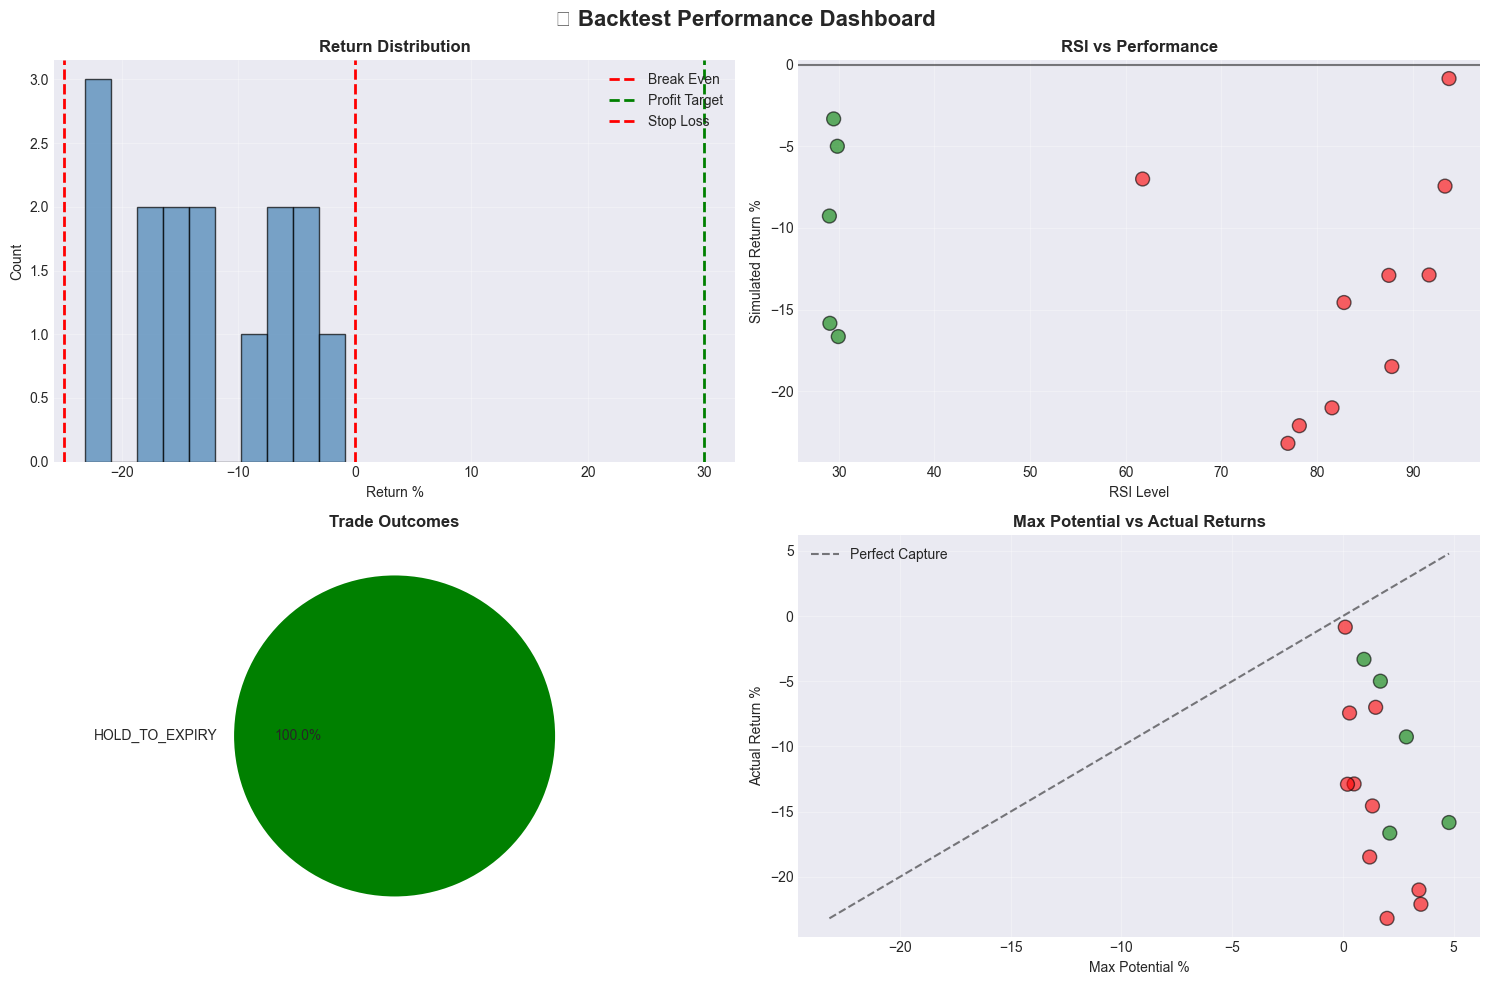

✅ Visualization dashboard created!


In [27]:
if not results_df.empty:
    # Create visualization dashboard
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('📊 Backtest Performance Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Return Distribution
    axes[0, 0].hist(results_df['simulated_return_pct'], bins=10, color='steelblue', 
                    edgecolor='black', alpha=0.7)
    axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Break Even')
    axes[0, 0].axvline(30, color='green', linestyle='--', linewidth=2, label='Profit Target')
    axes[0, 0].axvline(-25, color='red', linestyle='--', linewidth=2, label='Stop Loss')
    axes[0, 0].set_title('Return Distribution', fontweight='bold')
    axes[0, 0].set_xlabel('Return %')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. RSI vs Performance
    colors = ['red' if t == 'LONG PUT' else 'green' for t in results_df['trade_type']]
    scatter = axes[0, 1].scatter(results_df['rsi'], results_df['simulated_return_pct'], 
                                c=colors, s=100, alpha=0.6, edgecolors='black')
    axes[0, 1].axhline(0, color='black', linestyle='-', alpha=0.5)
    axes[0, 1].set_title('RSI vs Performance', fontweight='bold')
    axes[0, 1].set_xlabel('RSI Level')
    axes[0, 1].set_ylabel('Simulated Return %')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Outcome Pie Chart
    outcome_counts = results_df['outcome'].value_counts()
    colors_pie = ['green', 'red', 'orange']
    axes[1, 0].pie(outcome_counts.values, labels=outcome_counts.index, 
                   autopct='%1.1f%%', colors=colors_pie[:len(outcome_counts)])
    axes[1, 0].set_title('Trade Outcomes', fontweight='bold')
    
    # 4. Max Potential vs Actual
    axes[1, 1].scatter(results_df['max_potential_pct'], results_df['simulated_return_pct'], 
                       c=colors, s=100, alpha=0.6, edgecolors='black')
    # Add diagonal line for reference
    max_val = max(results_df['max_potential_pct'].max(), results_df['simulated_return_pct'].max())
    min_val = min(results_df['max_potential_pct'].min(), results_df['simulated_return_pct'].min())
    axes[1, 1].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='Perfect Capture')
    axes[1, 1].set_title('Max Potential vs Actual Returns', fontweight='bold')
    axes[1, 1].set_xlabel('Max Potential %')
    axes[1, 1].set_ylabel('Actual Return %')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Visualization dashboard created!")
else:
    print("❌ No data available for visualization")

## 💾 Save Results

In [28]:
if not results_df.empty:
    # Save backtest results
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    
    # Create directory if needed
    import os
    os.makedirs('data/exports/backtest', exist_ok=True)
    
    # Save detailed results
    results_file = f'data/exports/backtest/backtest_analysis_{timestamp}.csv'
    results_df.to_csv(results_file, index=False)
    
    # Create summary statistics
    summary_stats = {
        'analysis_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_trades': len(results_df),
        'winning_trades': len(results_df[results_df['profitable']]),
        'win_rate_pct': (len(results_df[results_df['profitable']]) / len(results_df)) * 100,
        'avg_return_pct': results_df['simulated_return_pct'].mean(),
        'best_trade_pct': results_df['simulated_return_pct'].max(),
        'worst_trade_pct': results_df['simulated_return_pct'].min(),
        'profit_targets_hit': len(results_df[results_df['outcome'] == 'PROFIT_TARGET_HIT']),
        'stop_losses_hit': len(results_df[results_df['outcome'] == 'STOP_LOSS_HIT'])
    }
    
    summary_df = pd.DataFrame([summary_stats])
    summary_file = f'data/exports/backtest/backtest_summary_{timestamp}.csv'
    summary_df.to_csv(summary_file, index=False)
    
    print(f"💾 Results saved to:")
    print(f"   📊 Detailed: {results_file}")
    print(f"   📈 Summary:  {summary_file}")
    
    # Export function for filtered results
    def export_winning_trades():
        """Export only winning trades"""
        winning = results_df[results_df['profitable']]
        if not winning.empty:
            win_file = f'data/exports/backtest/winning_trades_{timestamp}.csv'
            winning.to_csv(win_file, index=False)
            print(f"✅ Winning trades exported to: {win_file}")
        else:
            print("⚠️ No winning trades to export")
    
    print(f"\n📝 To export only winning trades: export_winning_trades()")
else:
    print("❌ No results to save")

💾 Results saved to:
   📊 Detailed: data/exports/backtest/backtest_analysis_20251112_160543.csv
   📈 Summary:  data/exports/backtest/backtest_summary_20251112_160543.csv

📝 To export only winning trades: export_winning_trades()


## 🎯 Key Insights & Next Steps

Based on this backtest analysis:

### 📊 What We Learned:
- **Win Rate**: How often our signals were profitable
- **Profit/Loss Ratio**: Average winner vs average loser
- **Target Efficiency**: How often we hit 30% profit targets
- **Risk Management**: How often stop losses saved us from bigger losses

### 🔄 Improvements to Consider:
1. **Adjust profit targets** based on volatility (ATR)
2. **Filter by RSI extremes** (focus on RSI >85 or <15)
3. **Add market condition filters** (trending vs sideways markets)
4. **Optimize holding periods** based on signal strength

### 📈 Next Steps:
1. Run this analysis daily to track signal accuracy
2. Compare performance across different market conditions
3. Refine entry/exit rules based on backtesting results
4. Build automated alerts for highest-probability setups